In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [113]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [204]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [206]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# training split, dev/validation split, test split
# 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [12]:
# cram 27 characters into 2-dimensional space (create embeddings table "C")
C = torch.randn((27, 2))

In [35]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [36]:
# 3 character context * 2 dimensional embedding space = 6 inputs
# number of neurons up to us - let's us 100
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [62]:
# emb @ W1 + b1 <- want to do this, but emb is [32,3,2] and need it to be [32,6] to multiply by W1 which is [6,100]
# use a view! (or concat and unbind, but less efficient because copying memory)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [61]:
h.shape

torch.Size([32, 100])

In [63]:
b1.shape

torch.Size([100])

In [68]:
# input is now 100 (neurons outputting from last layer) and output is 27 (27 characters)
# b2 is 27 since we're adding the bias to the output
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [74]:
logits = h @ W2 + b2

In [75]:
logits.shape

torch.Size([32, 27])

In [76]:
counts = logits.exp()

In [82]:
prob = counts / counts.sum(1, keepdim=True)

In [85]:
prob.shape

torch.Size([32, 27])

In [88]:
# get probabilities for the expected output labels
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.2098)

In [89]:
# -------- now made more respectable :) ---------------

In [207]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [288]:
g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn(27, 10, generator=g)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [289]:
sum(p.nelement() for p in parameters) # of total parameters

17697

In [290]:
for p in parameters:
    p.requires_grad = True

In [229]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [291]:
lri = []
lossi = []
stepi = []

In [292]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.01 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.9125081300735474


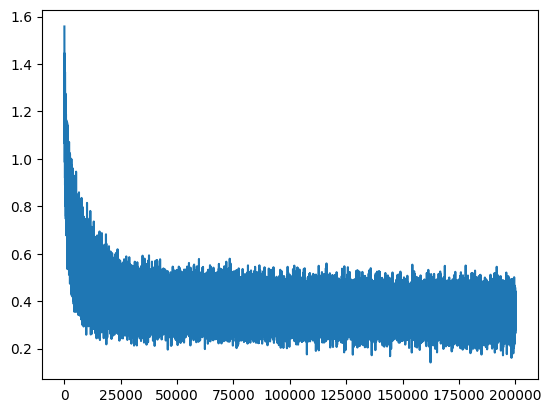

In [294]:
plt.plot(stepi, lossi)

In [295]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #(32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2866, grad_fn=<NllLossBackward0>)

In [296]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #(32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3001, grad_fn=<NllLossBackward0>)

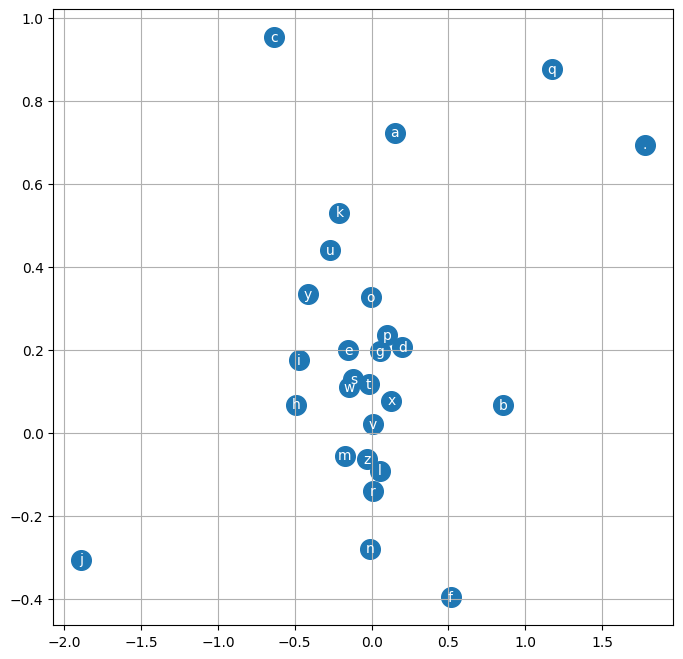

In [279]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [310]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carlah.
quill.
vill.
myli.
taty.
sacessa.
jazhnen.
delly.
chireei.
nellara.
chaiiv.
kaleig.
dham.
por.
debint.
sroelea.
jacki.
wattro.
dearyni.
jaceeni.
